## Yolo V3
### Reference
Joseph Redmon, et al., You Only Look Once: Uniﬁed, Real-Time Object Detection, 2016. [link](https://arxiv.org/abs/1506.02640)
### Contents
* Proposed basic neural network inspired by GoogLenet
* Architecture of baseline Yolo-v1
  * <img src='../etc/images/Yolo-1.png' width=300>
* Loss function
  * <img src='../etc/images/Yolo-2.png' width=300>
### Keys
* center_x, center_y, width, height, confidence 가 추가되어 학습 진행


In [1]:
import torch
from torch import nn
from torchinfo import summary

import pandas as pd
import numpy as np

In [2]:
class basic_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activation = nn.LeakyReLU(0.1, inplace=False)

    def forward(self, X):
        X = self.conv(X)
        X = self.bn(X)
        X = self.activation(X)
        return X

In [3]:
class reduction_conv(nn.Module):
  def __init__(self, in_channels, reduction_channels, out_channels, kernel_size=3, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.reduction = nn.Conv2d(
      in_channels=in_channels,
      out_channels=reduction_channels,
      kernel_size=1,
      bias=False
    )
    self.expansion = basic_conv(
      in_channels=reduction_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      padding='same',
    )

  def forward(self, X):
    X = self.reduction(X)
    X = self.expansion(X)
    return X

In [4]:
class Yolo_conv(nn.Module):
  def __init__(self, num_boxes, num_classes, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.adaptive_pool = nn.AdaptiveAvgPool2d(448)
    self.conv_seq_1 = nn.Sequential(
      basic_conv(
        in_channels=3,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
    self.conv_seq_2 = nn.Sequential(
      basic_conv(
        in_channels=64,
        out_channels=192,
        kernel_size=3,
        padding=1,
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
    self.conv_seq_3 = nn.Sequential(
      reduction_conv(
        in_channels=192,
        reduction_channels=128,
        out_channels=256,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=256,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
    self.conv_seq_4 = nn.Sequential(
      reduction_conv(
        in_channels=512,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=512,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=512,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=512,
        reduction_channels=256,
        out_channels=512,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=512,
        reduction_channels=512,
        out_channels=1024,
        kernel_size=3
      ),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2
      )
    )
    self.conv_seq_5 = nn.Sequential(
      reduction_conv(
        in_channels=1024,
        reduction_channels=512,
        out_channels=1024,
        kernel_size=3
      ),
      reduction_conv(
        in_channels=1024,
        reduction_channels=512,
        out_channels=1024,
        kernel_size=3
      ),
      basic_conv(
        in_channels=1024,
        out_channels=1024,
        kernel_size=3,
        padding=1,
      ),
      basic_conv(
        in_channels=1024,
        out_channels=1024,
        kernel_size=3,
        stride=2,
        padding=1,
      )
    )
    self.conv_seq_6 = nn.Sequential(
      basic_conv(
        in_channels=1024,
        out_channels=1024,
        kernel_size=3,
        padding=1,
      ),
      basic_conv(
        in_channels=1024,
        out_channels=1024,
        kernel_size=3,
        padding=1,
      )
    )
    self.conn_layer = nn.Sequential(
      basic_conv(
        in_channels=1024,
        out_channels=4096,
        kernel_size=1
      ),
      nn.Conv2d(
        in_channels=4096,
        out_channels=(5*num_boxes + num_classes),
        kernel_size=1
      )
    )

  def forward(self, X):
    X = self.adaptive_pool(X)
    X = self.conv_seq_1(X)
    X = self.conv_seq_2(X)
    X = self.conv_seq_3(X)
    X = self.conv_seq_4(X)
    X = self.conv_seq_5(X)
    X = self.conv_seq_6(X)
    X = self.conn_layer(X)
    return X

In [5]:
model = Yolo_conv(num_boxes=3, num_classes=4)
model(torch.randn((5, 3, 300, 412))).shape

torch.Size([5, 19, 7, 7])

In [6]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Yolo_conv                                --
├─AdaptiveAvgPool2d: 1-1                 --
├─Sequential: 1-2                        --
│    └─basic_conv: 2-1                   --
│    │    └─Conv2d: 3-1                  9,408
│    │    └─BatchNorm2d: 3-2             128
│    │    └─LeakyReLU: 3-3               --
│    └─MaxPool2d: 2-2                    --
├─Sequential: 1-3                        --
│    └─basic_conv: 2-3                   --
│    │    └─Conv2d: 3-4                  110,592
│    │    └─BatchNorm2d: 3-5             384
│    │    └─LeakyReLU: 3-6               --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-4                        --
│    └─reduction_conv: 2-5               --
│    │    └─Conv2d: 3-7                  24,576
│    │    └─basic_conv: 3-8              295,424
│    └─reduction_conv: 2-6               --
│    │    └─Conv2d: 3-9                  65,536
│    │    └─basic_conv: 3-10             1,180,6

## YoloV1 model for training animal-detection datasets
* number of parameters: 64,443,603

In [7]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import transforms
import cv2
from PIL import Image
import random

import sys
sys.path.append('..')

from python_scripts import data_setup
from python_scripts.Yolo_v3 import engine

In [8]:
train_data = pd.read_csv('../data/Animal Detection/train/train_output.csv')
train_data.head(10)

,filename,label
0,1,1 0.438281 0.529551 0.814063 0.704492
1,2,3 0.541016 0.524324 0.849219 0.672973
2,3,2 0.492500 0.517045 0.695000 0.725000
3,4,2 0.585156 0.525000 0.692187 0.785135
4,5,3 0.385547 0.645270 0.614844 0.698649\n3 0.559...
5,6,1 0.429688 0.596737 0.590625 0.778555
6,7,3 0.516797 0.504054 0.380469 0.929730
7,8,0 0.476526 0.520833 0.298122 0.404167
8,9,2 0.461184 0.470783 0.435774 0.877711\n2 0.813...
9,10,3 0.700781 0.626042 0.532813 0.739583


In [9]:
test_data = pd.read_csv('../data/Animal Detection/test/test_output.csv')
test_data.head()

,filename,label
0,1205,1 0.662500 0.482394 0.606250 0.607981\n1 0.207...
1,1206,3 0.703906 0.629977 0.367188 0.707260\n3 0.331...
2,1207,2 0.511250 0.540338 0.832500 0.615385
3,1208,0 0.551562 0.545946 0.484375 0.494595
4,1209,3 0.429000 0.564000 0.702000 0.749333\n3 0.402...


In [10]:
def pad_to_square(image):
    '''
    input: numpy image
    output: padded image, [x_pad, y_pad]
    '''

    c, h, w = image.shape
    if h == w:
        return image, [0, 0]

    add = abs(h - w) // 2
    if h < w:
        image = torch.concat([torch.zeros((c, add, w)), image, torch.zeros((c, add, w))], dim=1)
        return image, [0, add]
    else:
        image = torch.concat([torch.zeros((c, h, add)), image, torch.zeros((c, h, add))], dim=2)
        return image, [add, 0]

In [11]:
def resize(image, size):
    return F.interpolate(image.unsqueeze(0), size, mode='bilinear', align_corners=True).squeeze(0)

In [12]:
class dataset(Dataset):
    def __init__(self, data, path, transforms, image_size, multiscale=False) -> None:
        super().__init__()
        self.path = path
        self.data = data
        self.transforms = transforms
        self.image_size = image_size
        self.multiscale = multiscale
        self.batch_count = 0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # return (image_path, image(numpy), label(list))
        image_path = self.path + ('000' + str(self.data['filename'][index]))[-4:] + '.jpg'

        image = self.transforms(Image.open(image_path).convert('RGB'))
        _, h, w = image.shape

        image, pad = pad_to_square(image)
        _, h_padded, w_padded = image.shape

        label = [[float(s) for s in obj.split(' ')] for obj in self.data['label'][index].split('\n')]
        for l in label:
            l[1] = ((l[1] * w) + pad[0]) / w_padded
            l[2] = ((l[2] * h) + pad[1]) / h_padded
            l[3] *= w / w_padded
            l[4] *= h / h_padded

        return image_path, image, torch.tensor(label)

    def collate_fn(self, batch):
        paths, images, targets = list(zip(*batch))

        if self.multiscale and self.batch_count % 10 == 0:
            self.image_size = random.choice(range(320, 608 + 1, 32))

        images = torch.stack([resize(image, self.image_size) for image in images])
        self.batch_count += 1

        return paths, images, targets


In [13]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=1.5, saturation=1.5, hue=0.1),
    transforms.ToTensor()
])

In [14]:
train_dataset = dataset(
    data=train_data,
    path='../data/Animal Detection/train/',
    transforms=train_transforms,
    image_size=448,
    multiscale=False
)
train_dataset[0]

('../data/Animal Detection/train/0001.jpg',
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[1.0000, 0.4383, 0.5196, 0.8141, 0.4664]]))

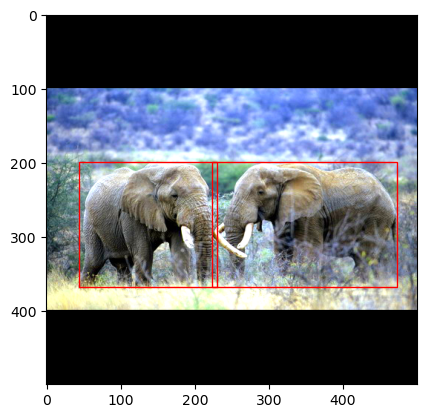

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as pts
fig, ax = plt.subplots()
ax.imshow(train_dataset[10][1].permute(1, 2, 0))
_, w, h = train_dataset[10][1].shape
count = 0
for o in train_dataset[10][2]:
    ax.add_patch(
        pts.Rectangle(
            ((o[1] - o[3]/2) * w, (o[2] - o[4]/2) * h),
            o[3] * w,
            o[4] * h,
            edgecolor='red',
            facecolor=(1,0,0,0)
        )
    )
    count += 1
    if count > 100:
        break

In [16]:
def calculate_iou(pred, target):
    '''
    pred: x, y, w, h of a predicted box
    target: x, y, w, h of a ground truth box
    returns a float number of iou
    '''

    area_pred = pred[2] * pred[3]
    area_target = target[2] * target[3]
    area_intersect_width = max(0, min(pred[0] + pred[2] / 2, target[0] + target[2] / 2) - max(pred[0] - pred[2] / 2, target[0] - target[2] / 2))
    area_intersect_height = max(0, min(pred[1] + pred[3] / 2, target[1] + target[3] / 2) - max(pred[1] - pred[3] / 2, target[1] - target[3] / 2))
    area_intersect = area_intersect_width * area_intersect_height

    return area_intersect / (area_pred + area_target - area_intersect)

In [17]:
def Yolo_loss(num_classes, lambda_coord=5, lambda_noobj=0.5):
    '''
    num_classes: number of classes
    lambda_coord: multiplied to coordinate losses
    lambda_noobj: multiplied to no_object losses

    returns a function which calculates the loss
        output: output of the model
        target: [[truth1, truth2,...for image1], [truth1, truth2...for image2]...]
    '''
    def loss_fn(output, target):
        n, _, d, d = output.shape
        pred_class_prob = F.softmax(output[:, :num_classes].permute(0, 2, 3, 1), dim=3)
        pred_box = F.relu(output[:, num_classes:].permute(0, 2, 3, 1).reshape(n, d, d, -1, 5))

        predout_box = pred_box.clone()

        target_class_prob = pred_class_prob.clone().detach()
        target_box = pred_box.clone().detach()
        for i in range(len(target)):
            for t in target[i]:
                x_min = t[1] - t[3] / 2
                x_max = t[1] + t[3] / 2
                y_min = t[2] - t[4] / 2
                y_max = t[3] + t[4] / 2

                row_min = int(y_min / (1 / d))
                row_max = int(y_max / (1 / d))
                col_min = int(x_min / (1 / d))
                col_max = int(x_max / (1 / d))

                class_prob = torch.tensor([0] * num_classes)
                class_prob[int(t[0])] = torch.tensor(1)
                target_class_prob[i, row_min:row_max+1, col_min:col_max+1] = class_prob

                target_box[i, row_min:row_max+1, col_min:col_max+1, :, 1:3] = t[1:3] * (lambda_coord ** 0.5)
                temp_box_xy = pred_box[i, row_min:row_max+1, col_min:col_max+1, :, 1:3] * (lambda_coord ** 0.5)

                target_box[i, row_min:row_max+1, col_min:col_max+1, :, 3:] = t[3:] * lambda_coord
                temp_box_wh = pred_box[i, row_min:row_max+1, col_min:col_max+1, :, 3:] * lambda_coord

                target_box[i, :, :, :, 0] = torch.tensor(0)
                target_box[i, row_min:row_max+1, col_min:col_max+1, :, 0] = torch.tensor(1)
                temp_box_conf = pred_box[i, :, :, :, 0] * lambda_noobj
                temp_box_conf[row_min:row_max+1, col_min:col_max+1, :] = pred_box[i, row_min:row_max+1, col_min:col_max+1, :, 0]

            predout_box[i, row_min:row_max+1, col_min:col_max+1, :, 1:3] = temp_box_xy
            predout_box[i, row_min:row_max+1, col_min:col_max+1, :, 3:] = temp_box_wh
            predout_box[i, :, :, :, 0] = temp_box_conf

        loss_xy = torch.sum(torch.square(predout_box[:, :, :, :, 1:3] - target_box[:, :, :, :, 1:3])) / n
        loss_wh = torch.sum(torch.square(torch.sqrt(predout_box[:, :, :, :, 3:]) - torch.sqrt(target_box[:, :, :, :, 3:]))) / n
        loss_conf = torch.sum(torch.square(predout_box[:, :, :, :, 0] - target_box[:, :, :, :, 0])) / n
        loss_class = torch.sum(torch.square(pred_class_prob - target_class_prob)) / n

        return loss_xy + loss_wh + loss_conf + loss_class

    return loss_fn


In [18]:
def pre_score_fn_Yolo(num_classes):

    def pre_score_fn(output):
        n, _, d, d = output.shape
        pred = output[:, 4:].permute(0, 2, 3, 1).reshape(n, d, d, -1, 5).reshape(n, -1, 5)
        pred_per_classes = [[[] for _ in range(num_classes)] for _ in range(n)]
        for i in range(n):
            for j, conf in enumerate(output[:, :4].permute(0, 2, 3, 1).reshape(n, d, d, -1).reshape(n, -1, 4)[i]):

                pred_per_classes[i][torch.argmax(conf)].extend(pred[i][3 * i: 3 * (i + 1)])

        return pred_per_classes

    return pre_score_fn

In [19]:
from collections import Counter

def average_precision(iou_th=0.5):
    '''
    iou_th: Threshold of iou for True positive

    returns a function which calculates the APs of an image
        preds: List of predictions with index as classes. len(preds) is equal to num_classes.
            The order of predictions is (confidence, x, y, w, h)
        target: List of ground truth of class and boxes.
            The order of ground truth is (class, x, y, w, h)
    '''

    def AP(preds, target):
        num_target_by_classes = Counter([int(t[0]) for t in target])

        preds_checked = {}
        for i, pred in enumerate(preds): # i: class
            if num_target_by_classes[i] == 0:
                continue
            # check if the prediction is true or false
            pred_sorted = sorted(pred, key=lambda x: x[0], reverse=True)
            duplication_check = set([])
            pred_checked = [False] * len(pred_sorted)
            for j, p in enumerate(pred_sorted):
                for k, t in enumerate(target):
                    if k in duplication_check:
                        continue
                    if t[0] == i and calculate_iou(p[1:], t[1:]) > iou_th:
                        pred_checked[j] = True

            preds_checked[i] = list(zip([p[0] for p in pred_sorted], pred_checked))

        return preds_checked

    return AP

In [20]:
def mean_average_precision(pred_checked):
    '''
    pred_checked: hashmap with key of classes and value of list of T/F with confidence
    '''

    AP = []
    for key in pred_checked.keys():
        num_target_by_classes = np.array([x[1] for x in pred_checked[key]]).sum()
        if num_target_by_classes == 0:
            continue
        # calculate AP
        all_pred_sorted = sorted(pred_checked[key], key=lambda x: x[0], reverse=True)
        precision_recall_11 = []
        precision = [0, 0]
        recall = [0, num_target_by_classes]
        for _, p in all_pred_sorted:
            if p:
                precision[0] += 1
                precision[1] += 1
                recall[0] += 1
            else:
                precision[1] += 1
            precision_calculated = precision[0] / precision[1]
            recall_calculated = recall[0] / recall[1]
            if int(recall_calculated * 10) >= len(precision_recall_11):
                for _ in range(len(precision_recall_11), int(recall_calculated * 10) + 1):
                    precision_recall_11.append(precision_calculated)
            if recall_calculated == 1:
                break

        AP.append(sum(precision_recall_11) / 11)

    if len(AP) == 0:
        return 0

    return sum(AP) / len(AP)

In [21]:
def score_fn_Yolo(preds_checker):
    '''
    preds: list of preds list by image [[pred1, pred2...for image1], [pred1, pred2...for image2]...]
        each pred is a list of predictions with index as classes.
    target: [[truth1, truth2,...for image1], [truth1, truth2...for image2]...]
    '''

    def score(preds, target):
        all_preds_checked = {}
        for i in range(len(preds)):
            preds_checked = preds_checker(preds[i], target[i])
            for key in preds_checked.keys():
                if key in all_preds_checked:
                    all_preds_checked[key].extend(preds_checked[key])
                else:
                    all_preds_checked[key] = preds_checked[key]

        return mean_average_precision(all_preds_checked)

    return score

In [22]:
train_sub_dataset, val_sub_dataset = data_setup.split_dataset(
    train_dataset,
    0.8
)

[INFO] Splitting dataset of length 1204 into splits of size: 963 and 241


In [23]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [24]:
learning_rate_list = [1e-4]
weight_decay_list = [1e-4]
epochs_list = [5]
batch_size_list = [16]

In [25]:
loss_fn = Yolo_loss(4)
pre_score_fn = pre_score_fn_Yolo(4)
ap_func = average_precision(0.5)
score_fn = score_fn_Yolo(ap_func)

In [26]:
result = engine.HP_tune_train(
    model=model,
    model_generator=None,
    model_weights=None,
    model_name='Yolo_v1_animal-detection',
    train_dataset=train_sub_dataset,
    test_dataset=val_sub_dataset,
    class_names=[0, 1, 2, 3],
    loss_fn=loss_fn,
    pre_score_fn=pre_score_fn,
    score_fn=score_fn,
    learning_rate_list=learning_rate_list,
    weight_decay_list=weight_decay_list,
    epochs_list=epochs_list,
    batch_size_list=batch_size_list,
    is_tensorboard_writer=False,
    device=device,
    gradient_accumulation_num=1,
    saving_max=False,
    metric_learning=False,
)

Yolo_v1_animal-detection_LR_0.0001_WD_0.0001_BS_16_GA_1:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/61 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 | Train_loss: 139.2176, Train_acc: 0.3180 | Test_loss: 206.1435, Test_acc: 0.4631


train:   0%|          | 0/61 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | Train_loss: 80.4041, Train_acc: 0.4545 | Test_loss: 68.8244, Test_acc: 0.4924


train:   0%|          | 0/61 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 | Train_loss: 74.8444, Train_acc: 0.6116 | Test_loss: 78.6238, Test_acc: 0.5992


train:   0%|          | 0/61 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 | Train_loss: 72.5654, Train_acc: 0.5592 | Test_loss: 67.8407, Test_acc: 0.7248


train:   0%|          | 0/61 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 | Train_loss: 72.9464, Train_acc: 0.5883 | Test_loss: 66.4750, Test_acc: 0.6604


In [41]:
_, x_test, y_input = train_dataset[9]
model1 = Yolo_conv(3, 4)
y_test = model1(x_test.unsqueeze(0))[:, 4:].permute(0, 2, 3, 1).reshape(-1, 5)
y_test.shape

torch.Size([147, 5])

In [43]:
x_test = resize(x_test, 448)
y_test = model(x_test.unsqueeze(0).to(device))[:, 4:].permute(0, 2, 3, 1).reshape(-1, 5)
y_test.shape

torch.Size([147, 5])

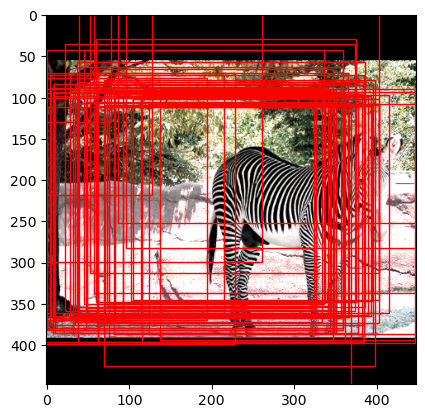

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as pts
fig, ax = plt.subplots()
ax.imshow(x_test.permute(1, 2, 0))
_, w, h = x_test.shape
count = 0
for o in y_test.detach().cpu():
    ax.add_patch(
        pts.Rectangle(
            ((o[1] - o[3]/2) * w, (o[2] - o[4]/2) * h),
            o[3] * w,
            o[4] * h,
            edgecolor='red',
            facecolor=(1,0,0,0)
        )
    )
    count += 1
    if count > 50:
        break